In [719]:
import sqlite3
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt

In [720]:
RT_LIMIT_LOWER = 4340
RT_LIMIT_UPPER = 4580

In [721]:
MS1_CE = 10

In [722]:
BASE_NAME = "/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
ALLPEPTIDES_FILENAME = '/Users/darylwilding-mcbride/Downloads/maxquant_results/txt/allPeptides.txt'
# BASE_NAME = "/home/ubuntu/HeLa_20KInt-rt-{}-{}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER)
# ALLPEPTIDES_FILENAME = '/home/ubuntu/maxquant_results/txt/allPeptides.txt'

CONVERTED_DATABASE_NAME = '{}/HeLa_20KInt.sqlite'.format(BASE_NAME)

In [723]:
CONVERTED_DATABASE_NAME

'/Users/darylwilding-mcbride/Downloads/HeLa_20KInt-rt-4340-4580/HeLa_20KInt.sqlite'

In [724]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
ms1_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy == {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
ms2_frame_properties_df = pd.read_sql_query("select frame_id,retention_time_secs from frame_properties where retention_time_secs >= {} and retention_time_secs <= {} and collision_energy <> {}".format(RT_LIMIT_LOWER,RT_LIMIT_UPPER,MS1_CE), db_conn)
db_conn.close()

In [725]:
ms1_frame_properties_df.head()

,frame_id,retention_time_secs
0,40411,4340.340330
1,40422,4341.521415
2,40433,4342.702923
3,40444,4343.883324
4,40455,4345.067491


In [726]:
ms2_frame_properties_df.head()

,frame_id,retention_time_secs
0,40408,4340.019894
1,40409,4340.127084
2,40410,4340.233855
3,40412,4340.446655
4,40413,4340.554812


In [727]:
ms1_frame_delay = ms1_frame_properties_df.iloc[1].retention_time_secs - ms1_frame_properties_df.iloc[0].retention_time_secs
ms1_frame_delay

1.1810854877303427

In [728]:
len(ms1_frame_properties_df)

203

In [729]:
RT_BASE_PEAK_WIDTH_SECS = float(30)

In [730]:
# get all the isolation windows
isolation_window_df = pd.read_pickle('/Users/darylwilding-mcbride/Downloads/isolation_window_df.pkl')

In [731]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,CollisionEnergy,Precursor
0,3,507,532,742.744835,2.427448,36.96,1
1,3,549,574,709.235759,2.092358,36.96,2
2,3,602,627,594.235088,2.000000,36.96,3
3,3,643,668,503.527768,2.000000,36.96,4
4,3,684,709,552.063870,2.000000,31.92,5


In [732]:
# add-in the retention time for the isolation windows and filter out the window not in range
isolation_window_df = pd.merge(isolation_window_df, ms2_frame_properties_df, how='left', left_on=['Frame'], right_on=['frame_id'])
isolation_window_df.drop(['frame_id', 'CollisionEnergy'], axis=1, inplace=True)
isolation_window_df.dropna(subset=['retention_time_secs'], inplace=True)
isolation_window_df['mz_lower'] = isolation_window_df.IsolationMz - (isolation_window_df.IsolationWidth / 2)
isolation_window_df['mz_upper'] = isolation_window_df.IsolationMz + (isolation_window_df.IsolationWidth / 2)
isolation_window_df['rt_lower'] = isolation_window_df.retention_time_secs - RT_BASE_PEAK_WIDTH_SECS
isolation_window_df['rt_upper'] = isolation_window_df.retention_time_secs + RT_BASE_PEAK_WIDTH_SECS

In [733]:
isolation_window_df.head()

,Frame,ScanNumBegin,ScanNumEnd,IsolationMz,IsolationWidth,Precursor,retention_time_secs,mz_lower,mz_upper,rt_lower,rt_upper
312803,40408,112,137,1135.738520,3.000000,147429,4340.019894,1134.238520,1137.238520,4310.019894,4370.019894
312804,40408,181,206,994.022363,3.000000,147430,4340.019894,992.522363,995.522363,4310.019894,4370.019894
312805,40408,263,288,1054.650881,3.000000,147451,4340.019894,1053.150881,1056.150881,4310.019894,4370.019894
312806,40408,324,349,789.368380,2.893684,147452,4340.019894,787.921538,790.815222,4310.019894,4370.019894
312807,40408,368,393,826.901660,3.000000,147453,4340.019894,825.401660,828.401660,4310.019894,4370.019894


In [734]:
len(isolation_window_df)

23727

Select one of the precursors

In [735]:
window_df = isolation_window_df.iloc[15000]
window_df

Frame                   41815.000000
ScanNumBegin              669.000000
ScanNumEnd                694.000000
IsolationMz               643.367227
IsolationWidth              2.000000
Precursor              155272.000000
retention_time_secs      4491.152876
mz_lower                  642.367227
mz_upper                  644.367227
rt_lower                 4461.152876
rt_upper                 4521.152876
Name: 327803, dtype: float64

In [736]:
mz_lower = window_df.mz_lower
mz_upper = window_df.mz_upper
scan_lower = int(window_df.ScanNumBegin)
scan_upper = int(window_df.ScanNumEnd)
rt_lower = window_df.rt_lower
rt_upper = window_df.rt_upper
precursor_id = int(window_df.Precursor)

In [737]:
# get the ms1 frame IDs
ms1_frame_ids = tuple(ms1_frame_properties_df.astype(int).values[:,0])


In [738]:
# load the cube's raw ms1 points
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_points_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and frame_id in {}".format(mz_lower, mz_upper, scan_lower, scan_upper, rt_lower, rt_upper, ms1_frame_ids), db_conn)
db_conn.close()

In [739]:
len(raw_points_df)

10960

In [740]:
raw_points_df.intensity.max()

3094

In [741]:
raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
0,41544,642.400403,681,87,4462.064699
1,41544,642.508312,679,10,4462.064699
2,41544,642.528297,672,40,4462.064699
3,41544,642.564269,675,58,4462.064699
4,41544,642.564269,678,44,4462.064699


In [742]:
MZ_MIN = mz_lower
MZ_MAX = mz_upper
MZ_BIN_WIDTH = 0.1

In [743]:
bins = np.arange(start=MZ_MIN, stop=MZ_MAX+(MZ_BIN_WIDTH*0.1), step=MZ_BIN_WIDTH)  # go slightly wider to accomodate the maximum value

In [744]:
bins

array([642.36722721, 642.46722721, 642.56722721, 642.66722721,
       642.76722721, 642.86722721, 642.96722721, 643.06722721,
       643.16722721, 643.26722721, 643.36722721, 643.46722721,
       643.56722721, 643.66722721, 643.76722721, 643.86722721,
       643.96722721, 644.06722721, 644.16722721, 644.26722721,
       644.36722721])

In [745]:
MZ_BIN_COUNT = len(bins)

In [746]:
# initialise an array of lists to hold the m/z and intensity values allocated to each bin
mz_values_array = np.empty(MZ_BIN_COUNT, dtype=np.object)
for idx in range(MZ_BIN_COUNT):
    mz_values_array[idx] = []


In [747]:
# gather the m/z values into bins
for r in zip(raw_points_df.mz, raw_points_df.intensity):
    mz = r[0]
    intensity = int(r[1])
    if (mz >= MZ_MIN) and (mz <= MZ_MAX): # it should already but just to be sure
        mz_array_idx = int(np.digitize(mz, bins)) # in which bin should this mz go
        mz_values_array[mz_array_idx].append((mz, intensity))

In [748]:
import peakutils

In [749]:
# compute the intensity-weighted m/z centroid and the summed intensity of the bins
peaks = []
for bin_idx in range(MZ_BIN_COUNT):
    if len(mz_values_array[bin_idx]) > 0:
        mz_values_for_bin = np.array([ list[0] for list in mz_values_array[bin_idx]])
        intensity_values_for_bin = np.array([ list[1] for list in mz_values_array[bin_idx]]).astype(int)
        mz_centroid = peakutils.centroid(mz_values_for_bin, intensity_values_for_bin)
        summed_intensity = intensity_values_for_bin.sum()
        peaks.append((mz_centroid,summed_intensity))

In [750]:
peaks

[(642.4068412822277, 4554),
 (642.5337244842575, 8678),
 (642.6418781537727, 53353),
 (642.6965968783323, 14980),
 (642.8096053650733, 10539),
 (642.9360873373437, 16958),
 (643.0168806926459, 489026),
 (643.1121067277205, 2840),
 (643.226860008136, 28205),
 (643.3493361888092, 520303),
 (643.3937575349045, 10943),
 (643.5356802588873, 19378),
 (643.6242099745265, 39722),
 (643.6883715068063, 292886),
 (643.8174608072086, 7743),
 (643.9338255528725, 26707),
 (644.0058974853173, 335999),
 (644.1220982603915, 5158),
 (644.2273736097846, 11940),
 (644.3316223629977, 297584)]

In [751]:
peaks_df = pd.DataFrame(peaks, columns=['mz_centroid','summed_intensity'])

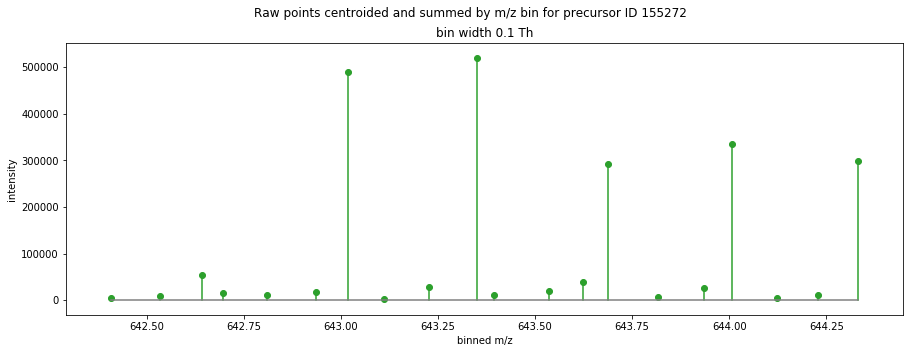

In [752]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(peaks_df.mz_centroid, peaks_df.summed_intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('binned m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Raw points centroided and summed by m/z bin for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

In [753]:
PROTON_MASS = 1.0073  # Mass of a proton in unified atomic mass units, or Da. For calculating the monoisotopic mass.


In [754]:
from ms_deisotope import deconvolute_peaks, averagine, scoring

# see https://github.com/mobiusklein/ms_deisotope/blob/ee4b083ad7ab5f77722860ce2d6fdb751886271e/ms_deisotope/deconvolution/api.py#L17
deconvoluted_peaks, _priority_targets = deconvolute_peaks(peaks, averagine=averagine.peptide, scorer=scoring.MSDeconVFitter(10.0))


In [755]:
peaks_l = []
for peak in deconvoluted_peaks:
    peaks_l.append((peak.mz, peak.neutral_mass, peak.intensity, peak.score, peak.signal_to_noise))
deconvoluted_peaks_df = pd.DataFrame(peaks_l, columns=['mz','neutral_mass','intensity','score','SN'])
# 'neutral mass' is the zero charge M, so we add the proton mass to get M+H (the monoisotopic mass)
deconvoluted_peaks_df['m_plus_h'] = deconvoluted_peaks_df.neutral_mass + PROTON_MASS


In [756]:
deconvoluted_peaks_df

,mz,neutral_mass,intensity,score,SN,m_plus_h
0,641.528971,640.521694,28056.0,77.240753,14028.000000,641.528994
1,643.226860,642.219584,40145.0,246.821113,20072.500000,643.226884
2,642.936087,1283.857622,43665.0,130.464778,21832.500000,1284.864922
3,643.122533,1284.230512,47720.0,132.580938,15906.666667,1285.237812
4,643.829945,1285.645337,305327.0,195.134523,152663.500000,1286.652637
5,643.014885,1926.022824,1638214.0,1726.033342,409553.500000,1927.030124


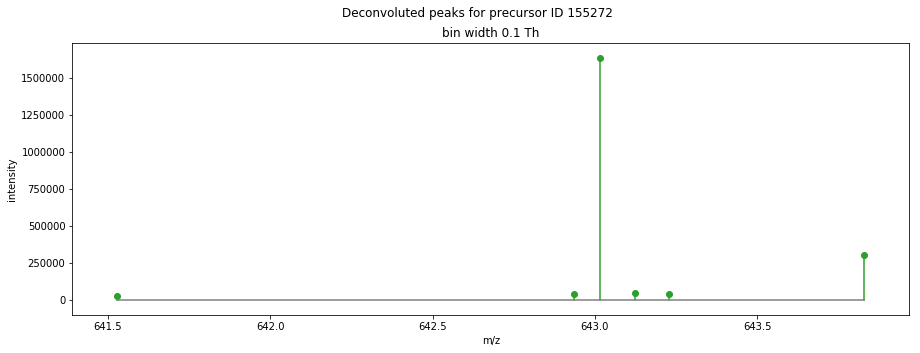

In [757]:
f, ax = plt.subplots()
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markerline, stemlines, baseline = ax.stem(deconvoluted_peaks_df.mz, deconvoluted_peaks_df.intensity, 'g')
plt.setp(markerline, 'color', colors[2])
plt.setp(stemlines, 'color', colors[2])
plt.setp(baseline, 'color', colors[7])
plt.xlabel('m/z')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.margins(0.06)
plt.suptitle('Deconvoluted peaks for precursor ID {}'.format(precursor_id))
plt.title('bin width {} Th'.format(MZ_BIN_WIDTH))
plt.show()

In [758]:
# assume the high score is for the monoisotopic peak
monoisotopic_mz = deconvoluted_peaks_df.iloc[deconvoluted_peaks_df.score.idxmax()].mz

In [759]:
monoisotopic_mz

643.0148845762092

In [760]:
monoisotopic_bin = int(np.digitize(monoisotopic_mz, bins))

Get the raw points for the monoisotopic peak

In [761]:
MZ_TOLERANCE_PPM = 5
MZ_TOLERANCE_PERCENT = MZ_TOLERANCE_PPM * 10**-4

In [762]:
monoisotopic_mz_ppm_tolerance = monoisotopic_mz * MZ_TOLERANCE_PERCENT / 100
monoisotopic_mz_lower = monoisotopic_mz - monoisotopic_mz_ppm_tolerance
monoisotopic_mz_upper = monoisotopic_mz + monoisotopic_mz_ppm_tolerance

In [763]:
monoisotopic_raw_points_df = raw_points_df[(raw_points_df.mz >= monoisotopic_mz_lower) & (raw_points_df.mz <= monoisotopic_mz_upper)]

In [764]:
monoisotopic_raw_points_df.head()

,frame_id,mz,scan,intensity,retention_time_secs
28,41544,643.012010,676,48,4462.064699
118,41555,643.016009,672,97,4463.244902
313,41577,643.016009,678,157,4465.608514
420,41588,643.012010,680,70,4466.791048
421,41588,643.012010,694,49,4466.791048


Collapsing the summed points onto the RT dimension

In [765]:
rt_df = monoisotopic_raw_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
rt_df

,frame_id,retention_time_secs,intensity
0,41544,4462.064699,48
1,41555,4463.244902,97
2,41577,4465.608514,157
3,41588,4466.791048,119
4,41687,4477.407621,154
5,41753,4484.495019,166
6,41764,4485.676983,98
7,41775,4486.857597,85
8,41786,4488.034919,505
9,41797,4489.217368,1408


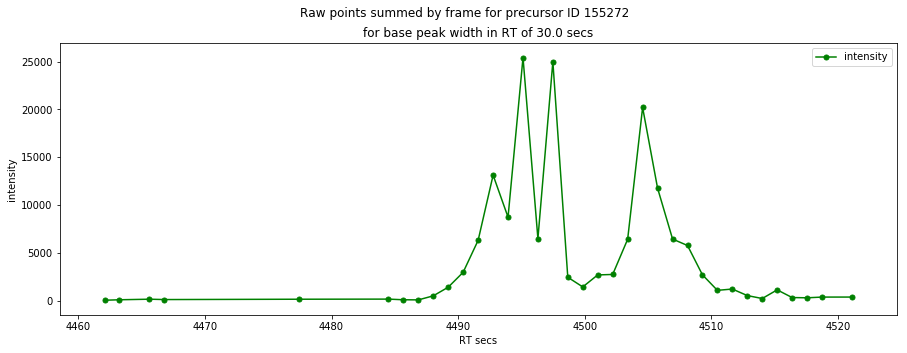

In [766]:
f, ax = plt.subplots()
ax.plot(rt_df.retention_time_secs, rt_df.intensity, marker='o', color='green', linestyle='-', ms=5)
plt.legend(loc='best')
plt.xlabel('RT secs')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points summed by frame for precursor ID {}'.format(precursor_id))
plt.title('for base peak width in RT of {} secs'.format(RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()

Collapsing the summed points onto the mobility dimension

In [767]:
scan_df = monoisotopic_raw_points_df.groupby(['scan'], as_index=False).intensity.sum()
scan_df

,scan,intensity
0,669,2314
1,670,1528
2,671,1397
3,672,2394
4,673,2921
5,674,3753
6,675,1768
7,676,4553
8,677,3017
9,678,7480


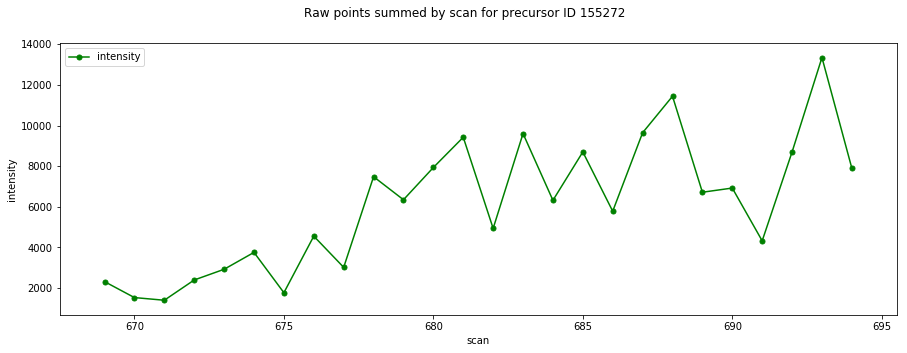

In [768]:
f, ax = plt.subplots()
ax.plot(scan_df.scan, scan_df.intensity, marker='o', color='green', linestyle='-', ms=5)
plt.legend(loc='best')
plt.xlabel('scan')
plt.ylabel('intensity')
f.set_figheight(5)
f.set_figwidth(15)
plt.suptitle('Raw points summed by scan for precursor ID {}'.format(precursor_id))
# plt.title('RT width {} secs'.format(2*RT_BASE_PEAK_WIDTH_SECS))
plt.margins(0.06)
plt.show()